# Packages

In [12]:
import numpy as np
from tensorflow import __version__
import matplotlib.pyplot as plt
%matplotlib inline
# import necessary building blocks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
Activation, Dropout, LeakyReLU
from tensorflow.keras.backend import clear_session, get_value
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, accuracy_score
__version__

'2.2.0'

# Dataset

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


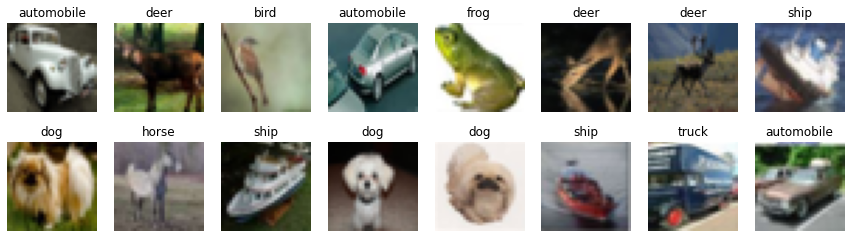

In [13]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]
# show random images from train
def show_dataset():
    cols = 8
    rows = 2
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(y_train))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(x_train[random_index, :])
            ax.set_title(cifar10_classes[y_train[random_index, 0]])
    plt.show()

show_dataset()

# Prepare data

In [0]:
# normalize inputs
x_train2 = x_train/255.- 0.5
x_test2 = x_test/255. - 0.5
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)

# Define CNN architecture

Stack __4__ convolutional layers with kernel size __(3, 3)__ with growing number of filters __(16, 32, 32, 64)__, use "same" padding.

Add __2x2__ pooling layer after every 2 convolutional layers (conv-conv-pool scheme).

Use __LeakyReLU__ activation with recommended parameter __0.1__ for all layers that need it (after convolutional and dense layers)

Add a dense layer with __256__ neurons and a second dense layer with __10__ neurons for classes. Remember to use __Flatten__ layer before first dense layer to reshape input volume into a flat vector!

Add __Dropout__ after every pooling layer (__0.25__) and between dense layers (__0.5__).

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    # clear default graph
    clear_session()
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same",
                     activation="relu", input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(LeakyReLU(0.1))
    model.add(Activation("softmax"))
    return model

# Train

In [16]:
# initial learning rate
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 10
model_filename = 'cifar.{0:03d}.hdf5'

# define our model
model = make_model()

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=Adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=1
)

Epoch 1/10
1563/1563 [==============================] - 191s 122ms/step - loss: 1.4247 - accuracy: 0.4926 - val_loss: 1.0461 - val_accuracy: 0.6312 - lr: 0.0050
Epoch 2/10
1563/1563 [==============================] - 190s 122ms/step - loss: 1.0017 - accuracy: 0.6474 - val_loss: 0.8363 - val_accuracy: 0.7111 - lr: 0.0045
Epoch 3/10
1563/1563 [==============================] - 190s 122ms/step - loss: 0.8478 - accuracy: 0.7070 - val_loss: 0.7660 - val_accuracy: 0.7353 - lr: 0.0041
Epoch 4/10
1563/1563 [==============================] - 191s 122ms/step - loss: 0.7592 - accuracy: 0.7341 - val_loss: 0.7433 - val_accuracy: 0.7502 - lr: 0.0036
Epoch 5/10
1563/1563 [==============================] - 190s 122ms/step - loss: 0.6946 - accuracy: 0.7575 - val_loss: 0.7043 - val_accuracy: 0.7598 - lr: 0.0033
Epoch 6/10
1563/1563 [==============================] - 191s 122ms/step - loss: 0.6450 - accuracy: 0.7739 - val_loss: 0.6767 - val_accuracy: 0.7681 - lr: 0.0030
Epoch 7/10
1563/1563 [============

# Evaluate model

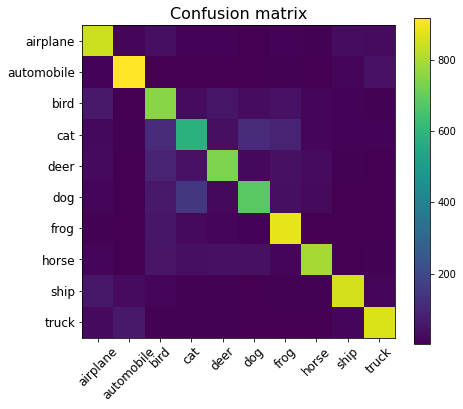

Test accuracy: 0.7916


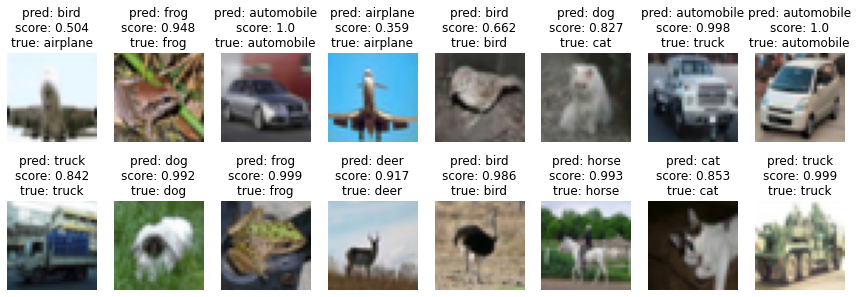

In [17]:
# make test predictions
y_pred_test = model.predict(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

# confusion matrix and accuracy
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()